# Reference Groups

Follow the instructions in README.md to set-up the code and libraries correctly.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet

Our language model for this taks is a ConceptNet Numberbatch embedding with and added counterfitting procedure to space out antonyms. We also disable spacy's default behavior of spitting dashses.

In [5]:
import spacy
from spacy.util import compile_infix_regex
from spacy.tokenizer import Tokenizer

data_file_path  = "./data/survey.csv"                  
output_folder  = f"output{data_file_path[6:-4]}/"

try:
    os.popen(f"mkdir {output_folder}")
except:
    print("folder existed already")

# Generate a counter-fitted numberbatch model and place it in
# the lib folder. We can load it back in using spacy.
numberbatch_path = "lib/counterfitting/numberbatch-counterfitted"  
nlp = spacy.load(numberbatch_path)

# Avoid splitting of dashes
def custom_tokenizer(nlp):
    inf = list(nlp.Defaults.infixes)                # Default infixes
    inf.remove(r"(?<=[0-9])[+\-\*^](?=[0-9-])")    # Remove the generic op between numbers or between a number and a -
    inf = tuple(inf)                               # Convert inf to tuple
    infixes = inf + tuple([r"(?<=[0-9])[+*^](?=[0-9-])", r"(?<=[0-9])-(?=-)"])  # Add the removed rule after subtracting (?<=[0-9])-(?=[0-9]) pattern
    infixes = [x for x in infixes if '-|–|—|--|---|——|~' not in x] # Remove - between letters rule
    infix_re = compile_infix_regex(infixes)

    return Tokenizer(nlp.vocab, prefix_search=None,
                                suffix_search=None,
                                infix_finditer=None,
                                token_match=None,
                                rules=None)
nlp.tokenizer = custom_tokenizer(nlp)

## Data Preprocessing

In [6]:
from lib.hard_launch import load_data, remove_anomaly, process_text, construct_participant_level_df
from lib.addons_enric import censor_ips

### 1. Text processing and construct participant level variables

The text processing pipeline is as follows:
1. Remove participants with incomplete surveys (fewer than 8 unique phrases/words).
2. Use enchant for spell checking. Adopt the suggested word with the highest confidence if it has appeared elsewhere in the survey.
3. Lemmatize all words except for verbs.
4. Remove censored words (non-semantic words).
5. Check if ConceptNet knows the bigrams and if so use ConceptNet bigram notation (e.g., gold digger => gold_digger)
6. Remove infrequent words (anything with a count <5)
7. Summarize bigrams at the blank level as their maximum.
8. Spell-check.
9. Remove repetitive words within 1 participant's answers.
10. Recalculate maxima.

The final dataframe is then:

**df[n_participant,]**:
* P3_adjust: adjust association score to nan if the inputted word is not valid
* mean_emb: avg 200 embedding of words for each participant
* avg_association: avg association for each valid word
* conn_with_brand: avg scoring about how closely parcipants can relate to brand
* conn_with_inf: avg scoring about how closely parcipants can relate to the influencer
* intentionality: avg scoring about the post intention to sell the featured product

In [ ]:
from lib.addons_enric import censor_ips
from lib.hard_launch import load_data, remove_anomaly, process_text, construct_participant_level_df

df = load_data(data_file_path)
df = remove_anomaly(df)
df = censor_ips(df)
df,invalid_word,val_word_cnt,df_corrected_words = process_text(df,nlp)
df = construct_participant_level_df(df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4120 entries, 0 to 4120
Columns: 150 entries, Source to intentionality
dtypes: bool(1), float64(88), int64(12), object(49)
memory usage: 4.7+ MB


### 2. Clustering valid words in the survey

The models use a variant of [Bayesian Guassian mixture](https://en.wikipedia.org/wiki/Mixture_model#Multivariate_Gaussian_mixture_model) with EM to yield:

$$
p(\boldsymbol{\theta} \mid \boldsymbol{x})=\sum_{i=1}^{K} \tilde{\phi}_{i} \mathcal{N}\left(\tilde{\boldsymbol{\mu}}_{i}, \tilde{\mathbf{\Sigma}}_{i}\right)
$$

More specifically we opt for a Weighted Dirichlet Prior GMM. We choose a high value of gamma to get more active components.

The estimation procedure gives us the weights which must sum to 1. When sorted, they linearly decrease in previous experiments making it hard to choose a cut-off. 

+ unlike finite models, which will almost always use all components as much as they can, and hence will produce wildly different solutions for different numbers of components, the Dirichlet process solution won’t change much with changes to the parameters, leading to more stability and less tuning.
+ only an upper bound of this number needs to be provided. Note however that the DPMM is not a formal model selection procedure, and thus provides no guarantee on the result.
- the extra parametrization necessary for variational inference and for the structure of the Dirichlet process can and will make inference slower, although not by much.
- as in variational techniques, but only more so, there are many implicit biases in the Dirichlet process and the inference algorithms, and whenever there is a mismatch between these biases and the data it might be possible to fit better models using a finite mixture.

[Src: See here for a detailed description](https://amueller.github.io/COMS4995-s18/slides/aml-16-032118-clustering-and-mixture-models/#40)

Output:

<font color='blue'> === Word Level === </font>

df_word[n_word,]:
* word - valid word ocurring in the survey
* embedding - word embedding
* label     - Each word's cluster label
* count     - number of occurrences in the entire survey

<font color='blue'> === Cluster Level === </font>

df_cluster[n_cluster,] :
* label: cluster label
* centroid: cluster centroid
* central_word: word in cluster that is closest to cluster centroid
* word[list(str)]: list of words within the cluster
* embedding[list[list(float)]]: list of all word embeddings in the cluster

In [ ]:
# Note: older clustering methods are stored in lib.addons_clustering
from lib.addons_enric import cluster_words

# Set-up
k              = 100
algorithm      = "weightedDPGMM"
membership_col = ['dist_from_centroid_'+str(i) for i in range(k)]

# Save how often every word appears for the weighted clustering methods
word_list   = list(val_word_cnt.keys())
weights     = np.array([val_word_cnt[w] for w in word_list])

# Cluster
df_word,df_cluster,gmm = cluster_words(word_list, weights, k=k, nlp=nlp)  # clustering on valid words

In [13]:
# add counts
df_word['count']       = df_word['word'].apply(lambda w: val_word_cnt[w])

# add total # of occurences in each cluster
#[len(ws) for ws in df_cluster.word
def count_n_occurences(word_list):
    count = 0
    for word in word_list:
        count += val_word_cnt[word]
    return count
df_cluster['observations'] = [count_n_occurences(ws) for ws in df_cluster.word]

# save to csv
df_cluster[["label","central_word","stdev","weight","observations","word"]].sort_values("observations",ascending=False).to_csv(f'{output_folder}/word_clustering.csv')

Save the cluster-wordlist that is shown at the end of the paper.

In [14]:
def top_k(words):
    cnts  = [val_word_cnt[w] for w in words]
    return ", ".join(list(np.array(words)[np.argsort(cnts)[::-1][:5]]))

df_cluster["top_words"] = df_cluster.word.apply(top_k)
df_cluster["top_words"] = df_cluster.word.apply(top_k)

df_cluster[["central_word","top_words"]].to_csv(f"{output_folder}top.csv")

### 3. Calculate cluster membership
<font color='blue'> === Word Level & Participant Level & Brand Level === </font>

**Calculate each word and each participant's similarity w.r.t. each word cluster centroid using cosine**
* Calculates a membership field called **'dist_from_centroid_X'** for every word. It is calculated as:
$$
\begin{aligned}
\text{sim}(\mathbf w_i, \boldsymbol C_j) &= 1-\cos(\mathbf w_i, \,\boldsymbol C_j) \\
&= \frac{w \cdot C}{\lVert w \cdot C \rVert}
\end{aligned}
$$
It is 1 for very close neighbors and 0 for very far away ones.

* Then we calculated the participant's similarity to clusters in **dist_from_centroid_X**  as the particpant level average:

$$
\text{sim}(P_i,\boldsymbol C_j)=\frac{1}{|P_i|}\sum_{\mathbf w \in P_i} \text{sim}(\mathbf  w, \boldsymbol C_j)
$$

* Then we calculate brand's similarity to clusters in **dist_from_centroid_X** as:
$$
\begin{aligned}
\text{sim}(B, \boldsymbol C_j) &= \frac{1}{Z}\sum_{P_k \in B} \sum_{\mathbf{w_i} \in P_k} \text{sim}(\mathbf w_i, \,\boldsymbol C_j)
\end{aligned}
$$

In [19]:
from lib.hard_launch import calc_word_membership, calc_part_membership
from lib.global_var import brand, treatment, lemmas

df_word  = calc_word_membership(df_word,df_cluster)  # calc word membership
df       = calc_part_membership(df,df_word)          # calc participant membership

#df_perbrand = df[[brand, treatment, lemmas]].groupby([brand, treatment]).sum().reset_index()
df_perbrand = df[[brand,treatment,lemmas]].groupby([brand,treatment]).apply(lambda x : x.sum())[['lemmas']].reset_index()
df_perbrand = calc_part_membership(df_perbrand, df_word)
df_brand    = df.groupby([brand,treatment])[membership_col].mean().reset_index()

### 4. Calculate membership variation

**Variation is calculated as follows:**
- Calculate the cosine similarity of each word's concept space vector against the average concept space vector of the participant
- Averaging the $l_2$ scores for each word

$$\text{variation}(P_j) = \frac{1}{|P_j|}\sum_{w\in P_j}{\ell_2(w, \mu_j)}$$
where $\mu_j$ is the mean membership score vector of the participant.

In [29]:
from lib.hard_launch import calc_mem_var, count_words_in_cluster
from scipy.spatial import distance

df['mem_var_l2']      = calc_mem_var(df,df_word, membership_col, "sqeuclidean")
df['cluster_counter'] = count_words_in_cluster(df,df_word,k)
df['coverage']        = df['cluster_counter'].apply(np.count_nonzero)

In [30]:
df['num_words'] = df.lemmas.apply(len)
df['coverage_normalized'] = df['coverage'] / df['num_words']

In [31]:
df.mem_var_l2.mean()

1.2427617853265487

Output:
df[n_participant,]:
* **mem_var**: variation of membership score.
* **coverage**: number of clusters covered in the participant's response


### 5. Membership dist from C
<font color='blue'> === Participant Level === </font>

df[n_participant,]:
* mem_l2_dist_from_C: euclidean dist of each participant's membership from C mean membership
* mem_cos_dist_from_C: cosine dist of each participant's membership from C mean membership

In [33]:
import scipy
from lib.hard_launch import get_membership_dist_from_C

def dist_l2(v1,v2):       
    return distance.norm((v1-v2),2)

df['mem_l2_dist_from_C'] = get_membership_dist_from_C(df, df_brand, membership_col, metric=dist_l2)

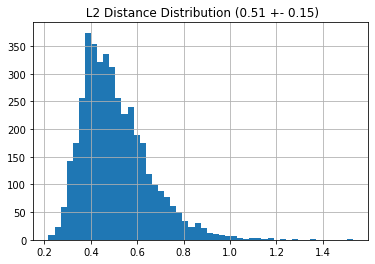

In [46]:
df['mem_l2_dist_from_C'].hist(bins=50);

plt.title(f" L2 Distance Distribution ({df['mem_l2_dist_from_C'].mean():.2f} +- {df['mem_l2_dist_from_C'].std():.2f})");

### 5. CSV exports

Export the data for SEM analysis in R and Stata.

In [42]:
# key variables output to csv
sem_cols = ['Source','ResponseId','id','handle','brand','age','gender','hour_pw','Q164','Q199',
            'avg_association','typicality',
            'mem_var_cos','mem_var_l2',
            'idea_change','mem_l2_dist_from_C',            #'mem_cos_dist_from_C',
            #'mem_jaccard_distance_words','mem_jaccard_distance_concepts','mem_l2_dist_from_C',            
            'user_perc','user_similarity',
            'resp_conf','conn_with_brand','conn_with_inf',
            'intentionality','sponsor_by','featured_product_typicality',
            'follow_likelihood','hour_pw','age','gender','coverage','coverage_normalized','num_words'
           ]
df[sem_cols].to_csv(f"{output_folder}data.csv", index=False)

In [43]:
from lib.global_var import P1_lemma, P2_lemma 

# most of the data is ready
df_inf = df.groupby(['brand','handle'])[['typicality','avg_association','idea_change','mem_var_l2',"user_similarity","coverage",'coverage_normalized','num_words']].mean().reset_index() #membership_col

# just need to add the top 5 cluster names
def words_for_x(all_words,only_cluster=None):
    all_words = [item for sublist in all_words for item in sublist]
    all_words = [item for sublist in all_words for item in sublist]

    if(only_cluster is not None):
        all_words_filtered =[]
        for word in all_words:
            if(cluster_label(word) in only_cluster):
                all_words_filtered.append(word)
        return all_words_filtered
    return all_words
def words_for_influencer(df, handle, only_cluster=None):
    all_words = df[df.handle == handle][P1_lemma+P2_lemma].values
    return words_for_x(all_words,only_cluster)
inf_words  = [words_for_influencer(df,handle) for handle in df_inf.handle]
words2labels = lambda words: [df_word[df_word.word == word].label.values[0] for word in words]
inf_lbls   = [words2labels(words) for words in  inf_words]

def labels_to_topkcentralwords(labels,k=9):
    lbl, cnt = np.unique(labels,return_counts=True)
    top_lbl  = lbl[np.argsort(cnt)][::-1][:k]
    return ", ".join(df_cluster.iloc[top_lbl].central_word.values)
inf_topk = [labels_to_topkcentralwords(lbls) for lbls in inf_lbls]

df_inf["topk_concepts"] = inf_topk
df_inf.to_csv(f"{output_folder}influencers.csv")

In [44]:
df_brand = df.groupby(['brand'])[['typicality','avg_association','idea_change','mem_var_l2',"user_similarity","coverage",'coverage_normalized','num_words']].mean().reset_index() #membership_col

def words_for_brand(df, name, only_cluster=None):
    all_words = df[(df.brand == name) & (df.treatment=='no')][P1_lemma+P2_lemma].values
    return words_for_x(all_words,only_cluster)

brand_words  = [words_for_brand(df,name) for name in df_brand.brand]
brand_lbls   = [words2labels(words) for words in  brand_words]
brand_top5   = [labels_to_topkcentralwords(lbls) for lbls in brand_lbls]
df_brand["topk_concepts"] = brand_top5
df_brand.to_csv(f"{output_folder}brands.csv")